In [1]:
import xarray as xr
import datetime as dt
import numpy as np
import glob
from barpa_read import drop_duplicates
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pandas as pd


In [2]:
files = []
start_year=2005; end_year=2015
for y in np.arange(start_year,end_year+1):
    for m in ["12","01","02"]:
        fid = "x_" + str(y) + m
        barpa_str1 = fid.split("_")[1]
        barpa_str2 = (dt.datetime.strptime(fid.split("_")[1]+"01","%Y%m%d") - dt.timedelta(days=1)).strftime("%Y%m")

        files = files + glob.glob("/scratch/tp28/cst565/ESCI/BARPAC-M_km2p2/era/erai/historical/r0/*/"+\
                                  barpa_str1+"*/pp0/*.nc")
        files = files + glob.glob("/scratch/tp28/cst565/ESCI/BARPAC-M_km2p2/era/erai/historical/r0/*/"+\
                                  barpa_str2+"*/pp0/*.nc")
        

In [3]:
barpac_m = drop_duplicates(xr.open_mfdataset(np.unique(files), concat_dim="time", combine="nested"))
barpac_m = barpac_m.sel({"time":(np.in1d(barpac_m["time.year"], np.arange(start_year,end_year+1))) & \
                        (np.in1d(barpac_m["time.month"],[12,1,2]))})

In [4]:
def preprocess(ds):
    year = ds["time"].units.split(" ")[-1]
    ds = ds.assign_coords(time=[dt.datetime(int(year),1,1,0) + dt.timedelta(hours=int(i)) for i in np.arange(len(ds.time.values))])
    return ds
    
wwlln = xr.open_mfdataset("/g/data/eg3/ab4502/ExtremeWind/ad_data/lightning_1hr/*.nc", decode_times=False, preprocess=preprocess)
wwlln = wwlln.resample({"time":"1D"}).sum()
wwlln = wwlln.sel({"time":(np.in1d(wwlln["time.year"], np.arange(start_year,end_year+1))) & \
                        (np.in1d(wwlln["time.month"],[12,1,2])) & \
                  (pd.to_datetime(wwlln.time.values) <= dt.datetime(2015,3,1))})


In [5]:
wwlln_subset = wwlln.sel({"lat":slice(barpac_m.latitude.min(), barpac_m.latitude.max()),
         "lon":slice(barpac_m.longitude.min(), barpac_m.longitude.max())})

barpa_subset = barpac_m.sel({"latitude":slice(wwlln.lat.min(), wwlln.lat.max()),
         "longitude":slice(wwlln.lon.min(), wwlln.lon.max())})

In [6]:
def draw_gridlines(ax):
    g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False
    g.xlabel_style={"size":12}
    g.ylabel_style={"size":12}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER         

# plt.figure(figsize=[18,8])
# ax1 = plt.subplot(1,2,1,projection=ccrs.PlateCarree())
# barpa_subset.n_lightning_fl.sum("time").plot(ax=ax1)
# ax1.coastlines()
# draw_gridlines(ax1)

# ax2 = plt.subplot(1,2,2,projection=ccrs.PlateCarree())
# wwlln_subset.Lightning_observed.sum("time").plot(ax=ax2)
# ax2.coastlines()
# draw_gridlines(ax2)

In [7]:
# barpa_binned = barpa_subset.n_lightning_fl.sum("time").groupby_bins("longitude",wwlln_subset.lon.values).sum().groupby_bins("latitude",wwlln_subset.lat.values).sum()

# plt.figure(figsize=[18,8])
# ax1 = plt.subplot(1,2,1,projection=ccrs.PlateCarree())
# barpa_binned.plot(ax=ax1)
# ax1.coastlines()
# draw_gridlines(ax1)

# ax2 = plt.subplot(1,2,2,projection=ccrs.PlateCarree())
# wwlln_subset.Lightning_observed.sum("time").plot(ax=ax2)
# ax2.coastlines()
# draw_gridlines(ax2)

In [8]:
# ax=plt.axes()
# wwlln_subset.groupby("time.year").sum().sum(("lat","lon")).Lightning_observed.plot(ax=ax,color="tab:blue",marker="o")

# ax2=ax.twinx()
# barpa_subset.groupby("time.year").sum().sum(("latitude","longitude")).n_lightning_fl.plot(ax=ax2,color="tab:orange",marker="o")

In [9]:
barpa_binned = (barpa_subset.n_lightning_fl.groupby_bins("longitude",wwlln_subset.lon.values).sum().groupby_bins("latitude",wwlln_subset.lat.values).sum() >= 1).sum("time")


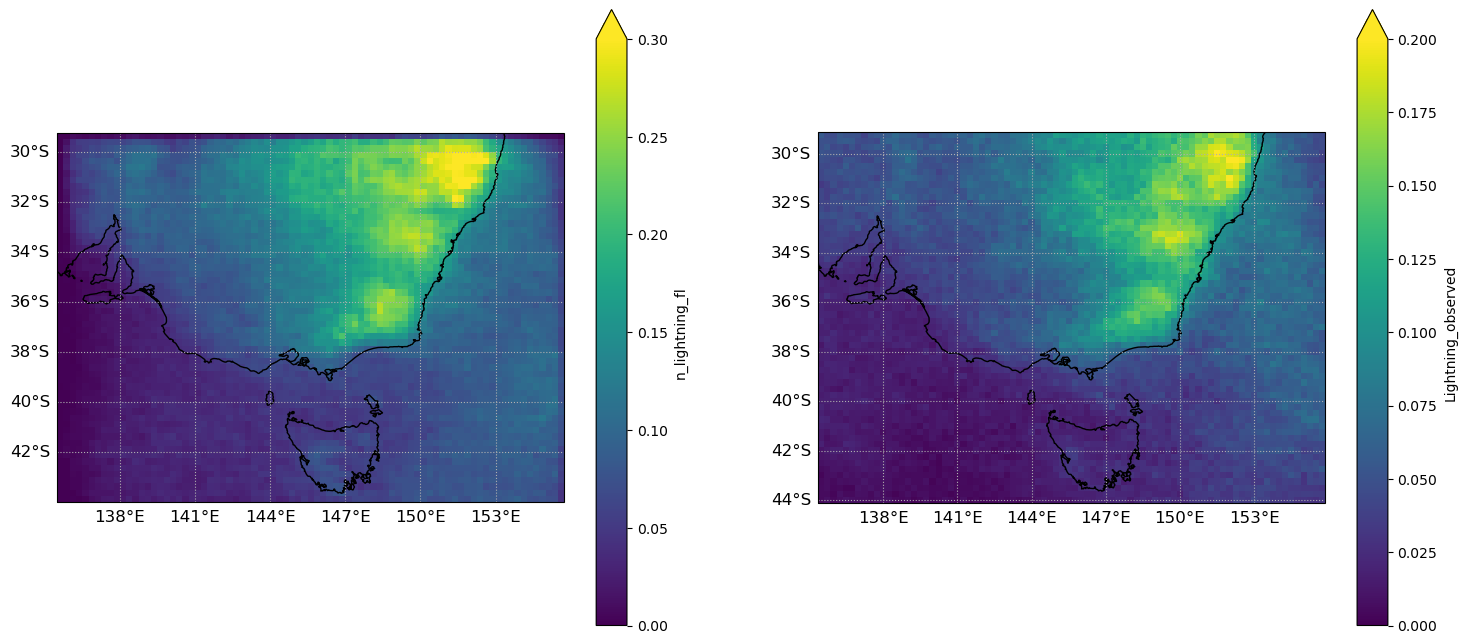

In [10]:
plt.figure(figsize=[18,8])
ax1 = plt.subplot(1,2,1,projection=ccrs.PlateCarree())
(barpa_binned / barpa_subset.time.shape[0]).plot(ax=ax1,vmin=0,vmax=0.3)
ax1.coastlines()
draw_gridlines(ax1)

ax2 = plt.subplot(1,2,2,projection=ccrs.PlateCarree())
((wwlln_subset.Lightning_observed >= 1).sum("time") / wwlln_subset.time.shape[0]).plot(ax=ax2,vmin=0,vmax=0.2)
ax2.coastlines()
draw_gridlines(ax2)

In [14]:
barpa_subset.n_lightning_fl.groupby_bins("longitude",wwlln_subset.lon.values).sum().groupby_bins("latitude",wwlln_subset.lat.values).sum().sum("time").plot()

KeyboardInterrupt: 